In [5]:
!pip install -q pandas seaborn scikit-plot scikit-image wandb torch-summary plotly umap-learn dotmap einops kornia opencv-python

In [3]:
!pip3 install -q torchvision # restart kernel

In [ ]:
!conda install -c conda-forge opencv

Retrieving notices: ...working... done
done
Solving environment: - 

In [1]:
import os
import torch
import random
import numpy as np
from train import train_regressor

def seed_it_all(seed=42):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
seed_it_all()

/opt/conda/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: libGL.so.1: cannot open shared object file: No such file or directory

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main


True

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Mean Absolute Error: 0.20703606102635239
Mean Squarred Error: 0.06559649791955617


ValueError: x and y must be the same size

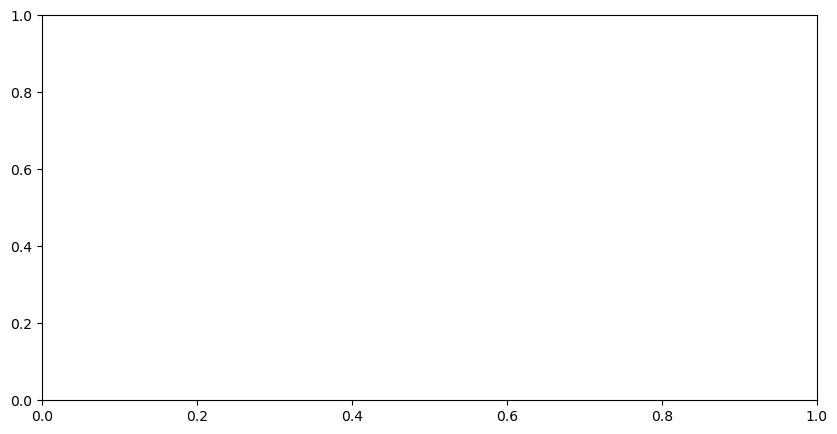

In [3]:
regressor = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

In [ ]:
print("Feature importances RandomForest:", regressor.feature_importances_)

LR: 
Mean Absolute Error: 0.2177400775970633
Mean Squarred Error: 0.08733567035093213

1. **Linear Regression**:
   - **Reasons to consider**: Linear regression is simple, interpretable, and computationally efficient. It assumes a linear relationship between the features and targets, which can be suitable for datasets with linear relationships or when interpretability is important.

2. **Decision Trees**:
   - **Reasons to consider**: Decision trees are non-parametric and can capture complex relationships between features and targets. They are robust to outliers and can handle both numerical and categorical data. However, they are prone to overfitting, especially with deep trees.

3. **Random Forests**:
   - **Reasons to consider**: Random forests are an ensemble method built on top of decision trees. They improve upon decision trees by reducing overfitting through bagging and random feature selection. They are robust, perform well on a wide range of datasets, and require minimal hyperparameter tuning.

4. **Gradient Boosting Machines (GBM)**:
   - **Reasons to consider**: GBM is an ensemble method that builds trees sequentially, each one correcting the errors of its predecessor. It typically performs better than random forests but may require more computational resources and tuning. XGBoost and LightGBM are popular implementations of GBM known for their efficiency and performance.

5. **Neural Network-based Models** (e.g., MLP, CNN):
   - **Reasons to consider**: Neural network-based models can capture complex nonlinear relationships in the data. They can automatically learn hierarchical features from the input data and perform well on large datasets. However, they may require more data and computational resources for training and tuning, and they are often considered as a choice when other simpler models do not perform well.

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the full-scale image
#img_path = "1.jpg"
img_path = "2.png"
img = Image.open(img_path).convert("RGB")
img_ds = transforms.Resize((img.size[1] // 2, img.size[0] // 2))(img)

def display_image(image_path):
    width, height = image_path.size
    print(f"Image size: {width}x{height} pixels")
    display(image_path)
#display_image(img)

img = preprocess(img).unsqueeze(0).to(DEVICE)
img_ds = preprocess(img_ds).unsqueeze(0).to(DEVICE)

In [ ]:
with torch.no_grad(), torch.cuda.amp.autocast():
    _, features = arniqa(img, img_ds, return_embedding=True, scale_score=True)
    features = features.cpu().numpy()
predicted_score = regressor.predict(features)
print("Predicted Score:", predicted_score)

In [ ]:
1: Predicted Score: [[ 0.22506177 -0.08953812 -0.17440884  0.41439405]]
2: Predicted Score: [[ 0.20012064  0.27296238  0.36209651 -0.09519467]]

1: Predicted Score: [[0.28  0.005 0.09  0.2  ]]
2: Predicted Score: [[0.295 0.01  0.445 0.23 ]]